In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from functools import reduce

def pauli_x():
    return np.array([[0, 1], [1, 0]])

def pauli_y():
    return np.array([[0, -1j], [1j, 0]])

def pauli_z():
    return np.array([[1, 0], [0, -1]])

def identity():
    return np.eye(2)

def tensor_product(gates):
    return reduce(np.kron, gates)

def extend_gate_to_many_qubits(gate, qubit, n_qubits):
    I = np.eye(2)
    gates = [I] * n_qubits
    gates[qubit] = gate
    return tensor_product(gates)

def to_density_matrix(state):
    return np.outer(state, state.conj())

def initialized_state(n):
    state = np.zeros(2**n)
    state[0] = 1
    return state

def spam_channel(rho, p2, n):
    rho = rho.astype(np.complex128)  # Ensure complex dtype
    new_rho = (1 - p2) * rho

    for qubit in range(n):
        X_n = extend_gate_to_many_qubits(pauli_x(), qubit, n)
        new_rho += (p2 / n) * X_n @ rho @ X_n.conj().T

    return new_rho / np.trace(new_rho)

def depolarizing_channel(rho, p1, n):
    rho = rho.astype(np.complex128)  # Ensure complex dtype
    new_rho = (1 - p1) * rho  # Fix variable name p2 → p1

    for qubit in range(n):
        new_rho += (p1 / 3) * (
            apply_pauli_on_qubit(rho, pauli_x(), qubit, n) +
            apply_pauli_on_qubit(rho, pauli_y(), qubit, n) +
            apply_pauli_on_qubit(rho, pauli_z(), qubit, n)
        )

    return new_rho / np.trace(new_rho)

def apply_pauli_on_qubit(rho, pauli, qubit, n):
    P_n = extend_gate_to_many_qubits(pauli, qubit, n)
    return P_n @ rho @ P_n.T.conj()

def shannon_entropy(probs):
    probs = np.real(probs)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))


def create_cat_state(n):
    """Create an n-qubit cat state (GHZ state)."""
    state = np.zeros(2**n)
    state[0] = 1 / np.sqrt(2)
    state[-1] = 1 / np.sqrt(2)
    return state




In [2]:
depolar_probs = [10**-i for i in np.linspace(.5,6,65)]
spam_probs = [10**-i for i in np.linspace(.5,6,65)]



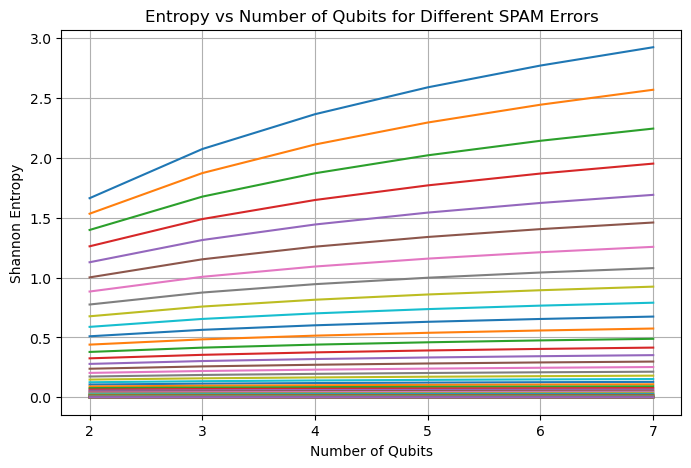

In [3]:
# Loop 1a: Vary SPAM error and analyze entropy slope for initialized state
slope_spam_variation = []
spam_error_entropies = []
for p2 in spam_probs:
    shannon_entropies = []
    for n in range(2, 8):
        state = initialized_state(n)#create_cat_state(n)
        rho = to_density_matrix(state)
        noisy_rho_init = spam_channel(rho, p2, n)
        noisy_rho = spam_channel(noisy_rho_init, p2, n)
        measured_probs = np.real(np.diag(noisy_rho))
        entropy = shannon_entropy(measured_probs)
        shannon_entropies.append(entropy)
    slope, _, _, _, _ = linregress(range(2, 8), shannon_entropies)
    slope_spam_variation.append(slope)
    spam_error_entropies.append(shannon_entropies)

# Plot entropy vs number of qubits for each SPAM value
plt.figure(figsize=(8, 5))
for i, p2 in enumerate(spam_probs):
    plt.plot(range(2, 8), spam_error_entropies[i])
plt.xlabel('Number of Qubits')
plt.ylabel('Shannon Entropy')

plt.title('Entropy vs Number of Qubits for Different SPAM Errors')
plt.grid()
plt.show()

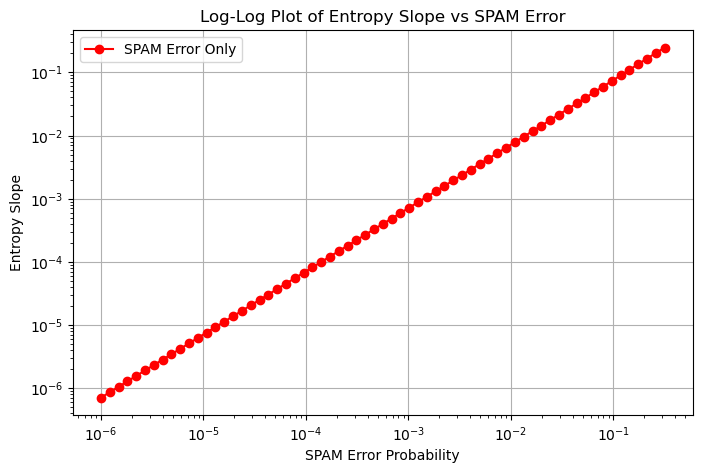

Slope of log-log plot (SPAM only): 1.0057930590421196


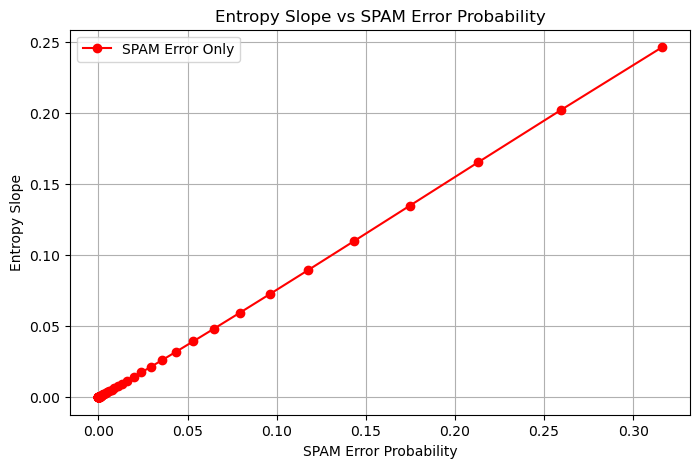

In [4]:
# Log-log plot of slopes vs SPAM error
plt.figure(figsize=(8, 5))
plt.loglog(spam_probs, slope_spam_variation, 'ro-', label='SPAM Error Only')
plt.xlabel('SPAM Error Probability')
plt.ylabel('Entropy Slope')
plt.legend()
plt.title('Log-Log Plot of Entropy Slope vs SPAM Error')
plt.grid()
plt.show()



# Compute slope of log-log plot
log_slope, _, _, _, _ = linregress(np.log(spam_probs), np.log(slope_spam_variation))
print(f'Slope of log-log plot (SPAM only): {log_slope}')


# Plot results
plt.figure(figsize=(8, 5))
plt.plot(spam_probs, slope_spam_variation, 'ro-', label='SPAM Error Only')
plt.xlabel('SPAM Error Probability')
plt.ylabel('Entropy Slope')
plt.legend()
plt.title('Entropy Slope vs SPAM Error Probability')
plt.grid()
plt.show()


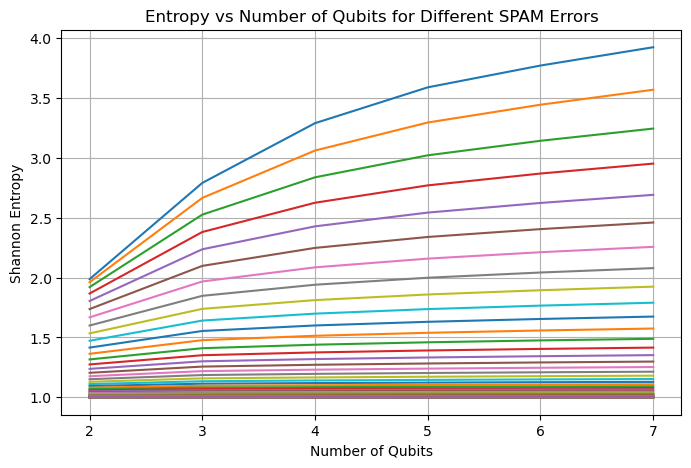

In [5]:
# Loop 1b: Vary SPAM error and analyze entropy slope for cat state
cat_slope_spam_variation = []
cat_spam_error_entropies = []
for p2 in spam_probs:
    shannon_entropies = []
    for n in range(2, 8):
        state = create_cat_state(n)
        rho = to_density_matrix(state)
        noisy_rho_init = spam_channel(rho, p2, n)
        noisy_rho = spam_channel(noisy_rho_init, p2, n)
        measured_probs = np.real(np.diag(noisy_rho))
        entropy = shannon_entropy(measured_probs)
        shannon_entropies.append(entropy)
    slope, _, _, _, _ = linregress(range(2, 8), shannon_entropies)
    cat_slope_spam_variation.append(slope)
    cat_spam_error_entropies.append(shannon_entropies)

# Plot entropy vs number of qubits for each SPAM value
plt.figure(figsize=(8, 5))
for i, p2 in enumerate(spam_probs):
    plt.plot(range(2, 8), cat_spam_error_entropies[i])
plt.xlabel('Number of Qubits')
plt.ylabel('Shannon Entropy')

plt.title('Entropy vs Number of Qubits for Different SPAM Errors')
plt.grid()
plt.show()

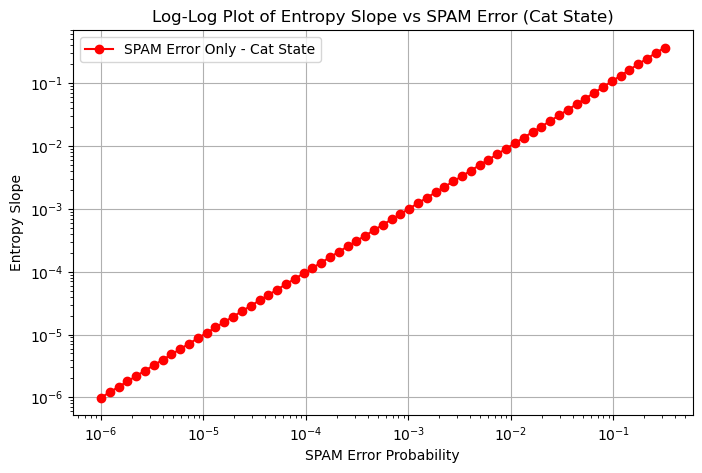

Slope of log-log plot (SPAM only): 1.0097916120014467


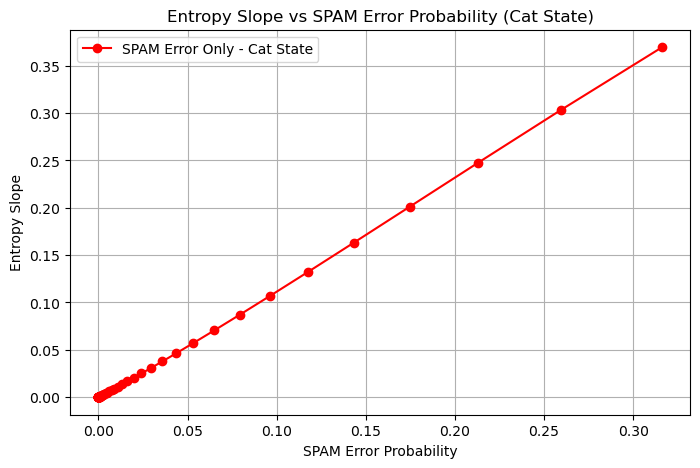

In [6]:
# Log-log plot of slopes vs SPAM error
plt.figure(figsize=(8, 5))
plt.loglog(spam_probs, cat_slope_spam_variation, 'ro-', label='SPAM Error Only - Cat State')
plt.xlabel('SPAM Error Probability')
plt.ylabel('Entropy Slope')
plt.legend()
plt.title('Log-Log Plot of Entropy Slope vs SPAM Error (Cat State)')
plt.grid()
plt.show()



# Compute slope of log-log plot
log_slope, _, _, _, _ = linregress(np.log(spam_probs), np.log(cat_slope_spam_variation))
print(f'Slope of log-log plot (SPAM only): {log_slope}')


# Plot results
plt.figure(figsize=(8, 5))
plt.plot(spam_probs, cat_slope_spam_variation, 'ro-', label='SPAM Error Only - Cat State')
plt.xlabel('SPAM Error Probability')
plt.ylabel('Entropy Slope')
plt.legend()
plt.title('Entropy Slope vs SPAM Error Probability (Cat State)')
plt.grid()
plt.show()


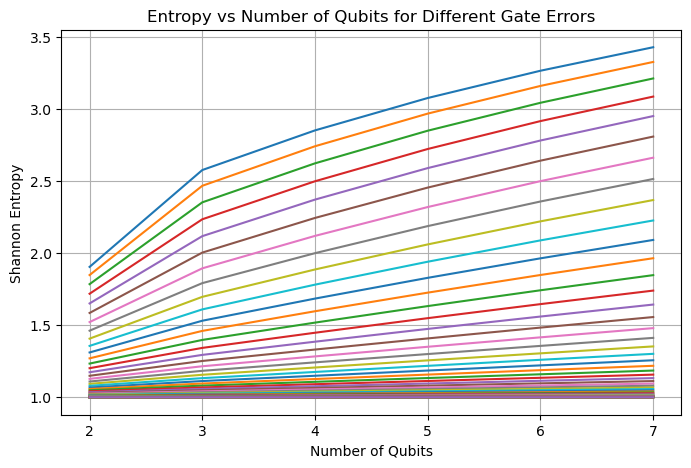

In [7]:
# Loop 2: Vary Depolarizing error and analyze entropy slope for cat state

slope_depolar_variation = []
depolar_error_entropies = []
for p2 in depolar_probs:
    shannon_entropies = []
    for n in range(2, 8):
        state = create_cat_state(n)
        rho = to_density_matrix(state)
        noisy_rho = depolarizing_channel(rho, p2, n) # Gate error
        measured_probs = np.real(np.diag(noisy_rho))
        entropy = shannon_entropy(measured_probs)
        shannon_entropies.append(entropy)        
        
    slope, _, _, _, _ = linregress(range(2, 8), shannon_entropies)
    slope_depolar_variation.append(slope)
    depolar_error_entropies.append(shannon_entropies)

# Plot entropy vs number of qubits for each SPAM value
plt.figure(figsize=(8, 5))
for i, p2 in enumerate(depolar_probs):
    plt.plot(range(2, 8), depolar_error_entropies[i])
plt.xlabel('Number of Qubits')
plt.ylabel('Shannon Entropy')

plt.title('Entropy vs Number of Qubits for Different Gate Errors')
plt.grid()
plt.show()

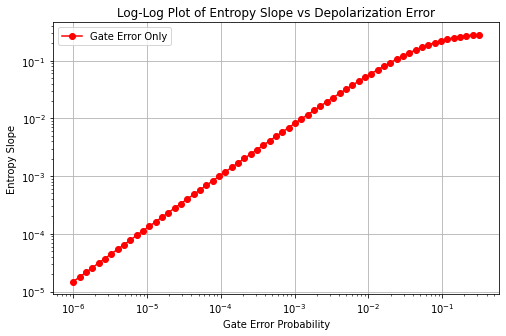

0.8280225747666728


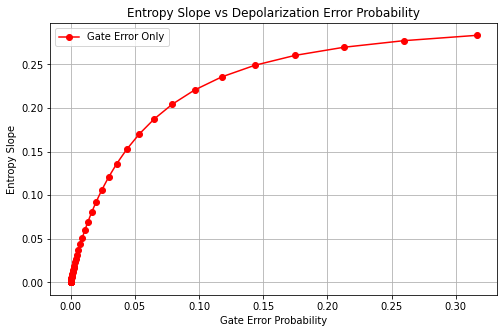

In [8]:
# Log-log plot of slopes vs SPAM error
plt.figure(figsize=(8, 5))
plt.loglog(depolar_probs, slope_depolar_variation, 'ro-', label='Gate Error Only')
plt.xlabel('Gate Error Probability')
plt.ylabel('Entropy Slope')
plt.legend()
plt.title('Log-Log Plot of Entropy Slope vs Depolarization Error')
plt.grid()
plt.show()



# Compute slope of log-log plot
log_slope, _, _, _, _ = linregress(np.log(depolar_probs), np.log(slope_depolar_variation))
print(log_slope)

# Plot results
plt.figure(figsize=(8, 5))
plt.plot(depolar_probs, slope_depolar_variation, 'ro-', label='Gate Error Only')
plt.xlabel('Gate Error Probability')
plt.ylabel('Entropy Slope')
plt.legend()
plt.title('Entropy Slope vs Depolarization Error Probability')
plt.grid()
plt.show()



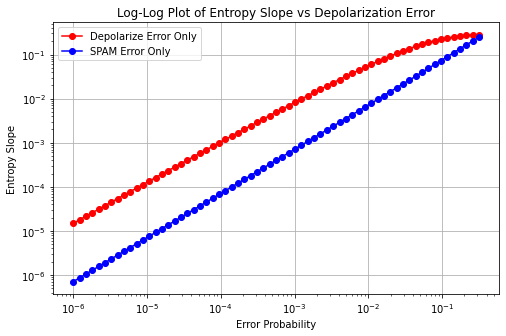

In [9]:
# Log-log plot of slopes vs SPAM error
plt.figure(figsize=(8, 5))
plt.loglog(depolar_probs, slope_depolar_variation, 'ro-', label='Depolarize Error Only')
plt.loglog(spam_probs, slope_spam_variation, 'bo-', label='SPAM Error Only')

plt.xlabel('Error Probability')
plt.ylabel('Entropy Slope')
plt.legend()
plt.title('Log-Log Plot of Entropy Slope vs Depolarization Error')
plt.grid()
plt.show()

In [10]:
def mitigate_spam(rho, noisy_rho, p2, n):
    
    for qubit in range(n):
        spam_mat = spam_channel(rho, p2, n)
                
        spam_mit = spam_mat@noisy_rho@spam_mat
        spam_mit/np.trace(spam_mit)        

    return spam_mit/np.trace(spam_mit)
        
        
n_qubits = 3  # Define number of qubits for mitigation
mitigated_states = []        
        
        
for i, delta_SP in enumerate(cat_slope_spam_variation):  # Loop over the entropy slopes
    p2 = spam_probs[i]  # Get the corresponding SPAM probability used in creation
    
    state = create_cat_state(n_qubits)

    rho_ideal = to_density_matrix(state)
    print(rho_ideal)
        
    rho_noisy_init = spam_channel(rho_ideal, p2, n_qubits)  # First SPAM application
    
    
    rho_noisy = spam_channel(rho_noisy_init, p2, n_qubits)  # Second SPAM application
    
    rho_mitigated = mitigate_spam(rho_ideal, rho_noisy, delta_SP, n_qubits)
    mitigated_states.append(rho_mitigated)
    
    print(f"Noisy State after SPAM application for delta_SP={delta_SP}, SPAM probability={p2}:")
    print(rho_noisy)
    print("Mitigated State:")
    print(rho_mitigated)

[[0.5 0.  0.  0.  0.  0.  0.  0.5]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0. ]
 [0.5 0.  0.  0.  0.  0.  0.  0.5]]
Noisy State after SPAM application for delta_SP=0.36949046150881143, SPAM probability=0.31622776601683794:
[[0.2504389 +0.j 0.        +0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.        +0.j 0.2504389 +0.j]
 [0.        +0.j 0.08318703+0.j 0.        +0.j 0.        +0.j
  0.        +0.j 0.        +0.j 0.08318703+0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.08318703+0.j 0.        +0.j
  0.        +0.j 0.08318703+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.08318703+0.j
  0.08318703+0.j 0.        +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.        +0.j 0.08318703+0.j
  0.08318703+0.j 0.        +0.j 0.        +0.j 0. 

  0.00000000e+00+0.j 4.99999000e-01+0.j]]
Mitigated State:
[[5.00000000e-01+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 5.00000000e-01+0.j]
 [0.00000000e+00+0.j 3.64419887e-20+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  3.64419887e-20+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 3.64419887e-20+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 3.64419887e-20+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  3.64419887e-20+0.j 3.64419887e-20+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 0.00000000e+00+0.j
  3.64419887e-20+0.j 3.64419887e-20+0.j 0.00000000e+00+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j]
 [0.00000000e+00+0.j 0.00000000e+00+0.j 3.64419887e-20+0.j
  0.00000000e+00+0.j 0.00000000e+00+0.j 3.64419887e-20+0.j
  0.00000000e+00+0.j 0.00000

In [11]:
def mitigate_depolar(rho, noisy_rho, p2, n):
    
    for qubit in range(n):
        depol_mat = depolarizing_channel(rho, p2, n)
                
        depol_mit = depol_mat@noisy_rho@depol_mat
                
    return depol_mit/np.trace(depol_mit)
        
        
n_qubits = 2  # Define number of qubits for mitigation
depolar_mitigated_states = []        
        
        
for i, delta_SP in enumerate(slope_depolar_variation):  # Loop over the entropy slopes
    p2 = depolar_probs[i]  # Get the corresponding SPAM probability used in creation
    
    state = create_cat_state(n_qubits)
       
    rho_ideal = to_density_matrix(state)
    print(rho_ideal)

    noisy_rho = depolarizing_channel(rho_ideal, p2, n_qubits) # Gate error
    
    rho_mitigated = mitigate_depolar(rho_ideal, noisy_rho, delta_SP, n_qubits)
    depolar_mitigated_states.append(rho_mitigated)
    
    print(f"Noisy State after SPAM application for delta_SP={delta_SP}, SPAM probability={p2}:")
    print(noisy_rho)
    print("Mitigated State:")
    print(np.real(rho_mitigated))
    
    
    

[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
Noisy State after SPAM application for delta_SP=0.28334804309120887, SPAM probability=0.31622776601683794:
[[0.33983128+0.j 0.        +0.j 0.        +0.j 0.17966257+0.j]
 [0.        +0.j 0.16016872+0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.16016872+0.j 0.        +0.j]
 [0.17966257+0.j 0.        +0.j 0.        +0.j 0.33983128+0.j]]
Mitigated State:
[[0.47987251 0.         0.         0.45974501]
 [0.         0.02012749 0.         0.        ]
 [0.         0.         0.02012749 0.        ]
 [0.45974501 0.         0.         0.47987251]]
[[0.5 0.  0.  0.5]
 [0.  0.  0.  0. ]
 [0.  0.  0.  0. ]
 [0.5 0.  0.  0.5]]
Noisy State after SPAM application for delta_SP=0.2772303765605244, SPAM probability=0.25945527214040154:
[[0.3626627 +0.j 0.        +0.j 0.        +0.j 0.22532541+0.j]
 [0.        +0.j 0.1373373 +0.j 0.        +0.j 0.        +0.j]
 [0.        +0.j 0.        +0.j 0.1373373 +0.j 0